This notebook is for making changes to figures for presenting shuffle analysis.

It works together with scripts "deploy_shuffle_clustering.py" and "run_shuffle_clustering.py" which are in vba repo, to generate shuffled datasets, coclustering matrices and labels for each type of shuffle.

To do:
* remove probability from plots, plot size diff only
* set not matched cluster size to 0 (not nan)
* invert colors of SSE heatmaps
* add statistics to cluster size differences
* plot area and depth info using bars



In [61]:
import os
import numpy as np

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import seaborn as sns

sns.set_context('notebook', font_scale=1, rc={'lines.markeredgewidth': 1})



In [62]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [64]:
import visual_behavior.visualization.utils as utils
import visual_behavior_glm.GLM_analysis_tools as gat

palette_experience = utils.get_experience_level_colors()
palette_cre = utils.get_cre_line_colors()

In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:

# # load experiments table
experiments_table = loading.get_platform_paper_experiment_table()
# # limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)


3921 cells in matched cells table


In [67]:
figsizes = [(20,7), (10,7), (20,7)]
thresholds = [0.10]

In [68]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [69]:
# set params for saving
folder = '220820_presentation'
file_dir = '220627_shuffle_test/files'

In [70]:
base_dir = r'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [71]:
# create folder to load and save to
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

#### Load original feature matrix,, meta data and cluster labels

In [72]:
filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(base_dir,file_dir, filename), key='df')

In [73]:
filename = 'cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5'
df_meta = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [74]:
filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
original_cluster_labels = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [75]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line].index.values
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

In [76]:
original_cluster_labels.head(2)

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2


#### compute mean dropout scores for original data

In [77]:
cre_mean_dropout_scores = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df)
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    if cre_line == 'Slc17a7-IRES2-Cre':
        print('changing stuff')
        mean_dropout_scores=mean_dropout_scores.rename(columns= {4:5,5:4})
        mean_dropout_scores = mean_dropout_scores.reindex(sorted(mean_dropout_scores), axis=1)
    cre_mean_dropout_scores[cre_line] = mean_dropout_scores

changing stuff


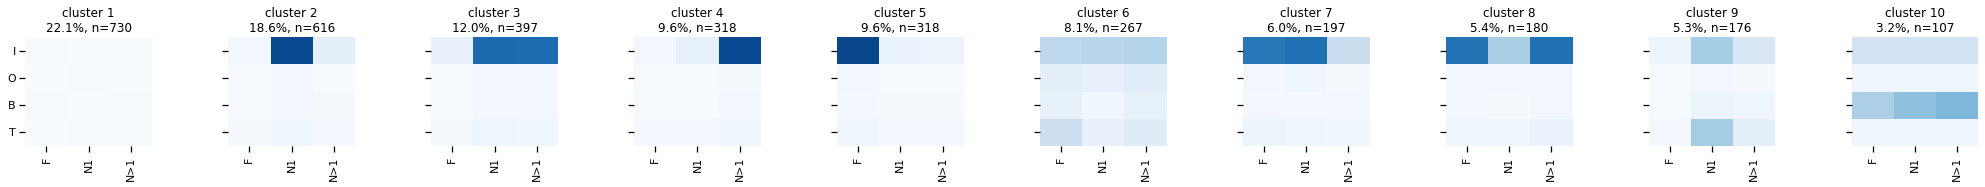

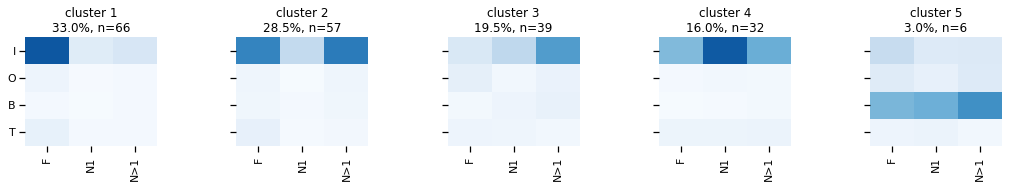

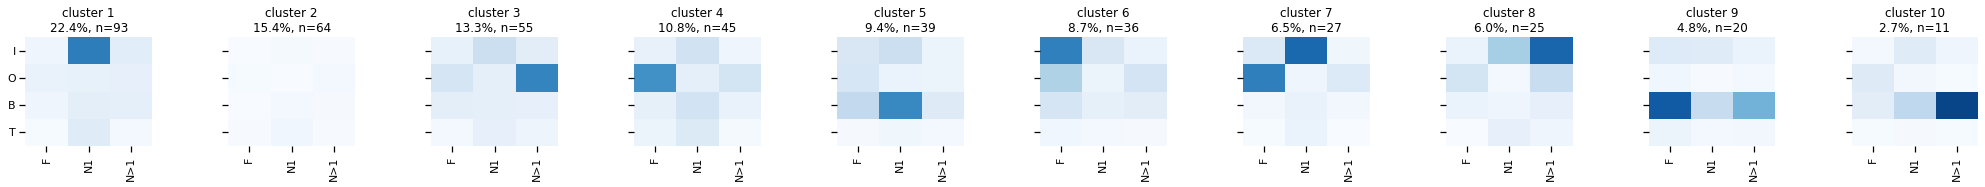

In [79]:
# plot original clusters
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_original',
                                )


#### load shuffled datasets into one dictionary

In [80]:
shuffle_types = ['experience', 'experience_within_cell','full_experience']
# randomize 150 samples of shuffled data
# n_boots = np.random.randint(0, 500, 150)
n_boots = np.arange(500)

#### load cluster labels for each dataset into one dictionary

In [81]:
%%time
shuffle_type_labels = {}
for shuffle_type in shuffle_types:
    cre_labels_shuffled = {}
    for cre_line in cre_lines:
        nb_labels_shuffled = {}                       
        for n, n_boot in enumerate(n_boots):
            nb_filename ='{}_{}_nb{}_cluster_labels.h5'.format(cre_line, shuffle_type, n_boot) 
            full_filename = os.path.join(base_dir, file_dir, nb_filename)
            nb_labels_shuffled[n] = pd.read_hdf(full_filename, key = 'clustered_df')
        
        #print(shuffle_type, cre_line, index)
        cre_labels_shuffled[cre_line] = nb_labels_shuffled
    shuffle_type_labels[shuffle_type] = cre_labels_shuffled
    

Wall time: 6min 4s


In [82]:
%%time
# this takes a few minutes
shuffle_type_df = {}
for shuffle_type in shuffle_types:
    cre_df_shuffled = {}
    for cre_line in cre_lines:
        nb_shuffled = {}
        for n, n_boot in enumerate(n_boots):
            nb_filename ='{}_{}_nb{}.h5'.format(cre_line, shuffle_type, n_boot)
            nb_shuffled[n] = pd.read_hdf(os.path.join(base_dir, file_dir, nb_filename), key = 'df')
         
        cre_df_shuffled[cre_line] = nb_shuffled
    shuffle_type_df[shuffle_type] = cre_df_shuffled

Wall time: 4min 32s


#### compute mean dropout scores for shuffled dfs


In [83]:
shuffle_type_mean_dropout_scores = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n, n_boot in enumerate(n_boots):
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n]
            mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores
        cre_mean_dropout_scores_shuffled[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores[shuffle_type] = cre_mean_dropout_scores_shuffled

In [25]:
### this takes a lot of time so run it at your own risk
### plot clusters
# for shuffle_type in shuffle_types[::-1]:
#     for cre_line in cre_lines[::-1]:
#         for n, n_boot in enumerate(n_boots[:50]):
#             feature_matrix = shuffle_type_df[shuffle_type][cre_line][n]
#             cluster_df = shuffle_type_labels[shuffle_type][cre_line][n].set_index('cell_specimen_id')
#             sort_order = {cre_line: vba_clust.get_sorted_cluster_ids(cluster_df)}
#             vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
#                                    sort_order=sort_order, rename_clusters=True, save_dir=save_dir, folder='shuffled_plots', 
#                                         suffix='_nb'+str(n_boot)+'_'+shuffle_type)
#             plt.close('all')

### compute SSE

In [84]:
shuffle_type_SSE = {}
for shuffle_type in shuffle_types:
    cre_SSE = {}
    for cre_line in cre_lines:
        nb_sse = {}
        original_df = cre_mean_dropout_scores[cre_line]
        for n, n_boot in enumerate(n_boots):
            shuffled_df = shuffle_type_mean_dropout_scores[shuffle_type][cre_line][n]
            sse = vba_clust.compute_SSE(original_df, shuffled_df)
            nb_sse[n] = sse
        cre_SSE[cre_line] = nb_sse
    shuffle_type_SSE[shuffle_type] = cre_SSE
        

### get cluster mapping

In [85]:
thresholds

[0.1]

In [86]:
threshold_SSE_mapping = {}
for threshold in thresholds:
    shuffle_type_SSE_mapping = {}
    for shuffle_type in shuffle_types:
        cre_SSE_mapping = {}
        for cre_line in cre_lines:
            nb_sse_mapping = {}
            nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
            cluster_mapping = vba_clust.get_cluster_mapping(nb_matrix, threshold = threshold)
            cre_SSE_mapping[cre_line] = cluster_mapping
        shuffle_type_SSE_mapping[shuffle_type] = cre_SSE_mapping
    threshold_SSE_mapping[threshold] = shuffle_type_SSE_mapping


In [87]:
shuffle_type_dict = {}
shuffle_type_dict['experience']='cell ID'
shuffle_type_dict['experience_within_cell']='exp labels'
shuffle_type_dict['full_experience']='both'


In [88]:

shuffle_type_SSE_values = {}
for shuffle_type in shuffle_types:
    cre_SSE_values = {}
    for cre_line in cre_lines:
        nb_matrix = shuffle_type_SSE[shuffle_type][cre_line]
        cluster_mapping_SSE = vba_clust.get_mapped_SSE_values(nb_matrix, threshold = threshold)
        cre_SSE_values[cre_line] = cluster_mapping_SSE
    shuffle_type_SSE_values[shuffle_type] = cre_SSE_values


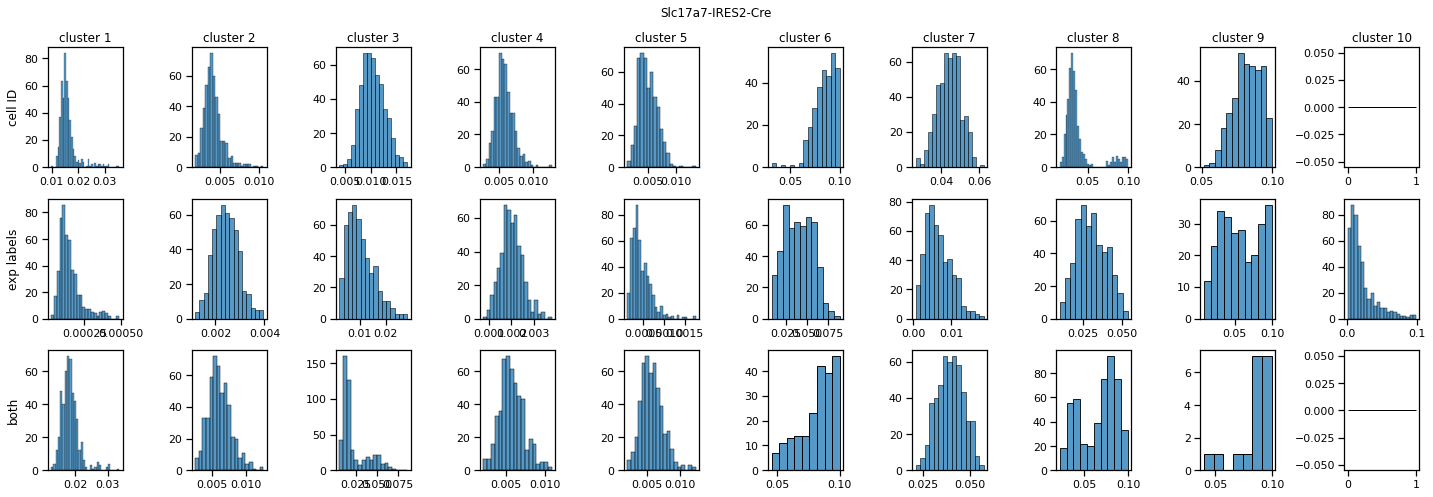

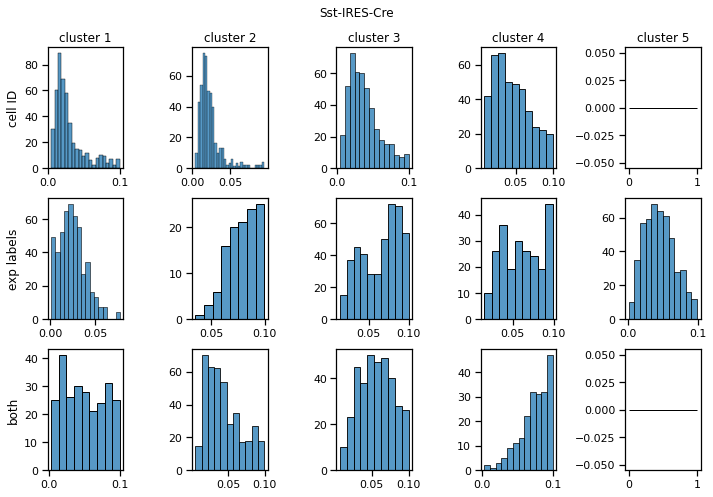

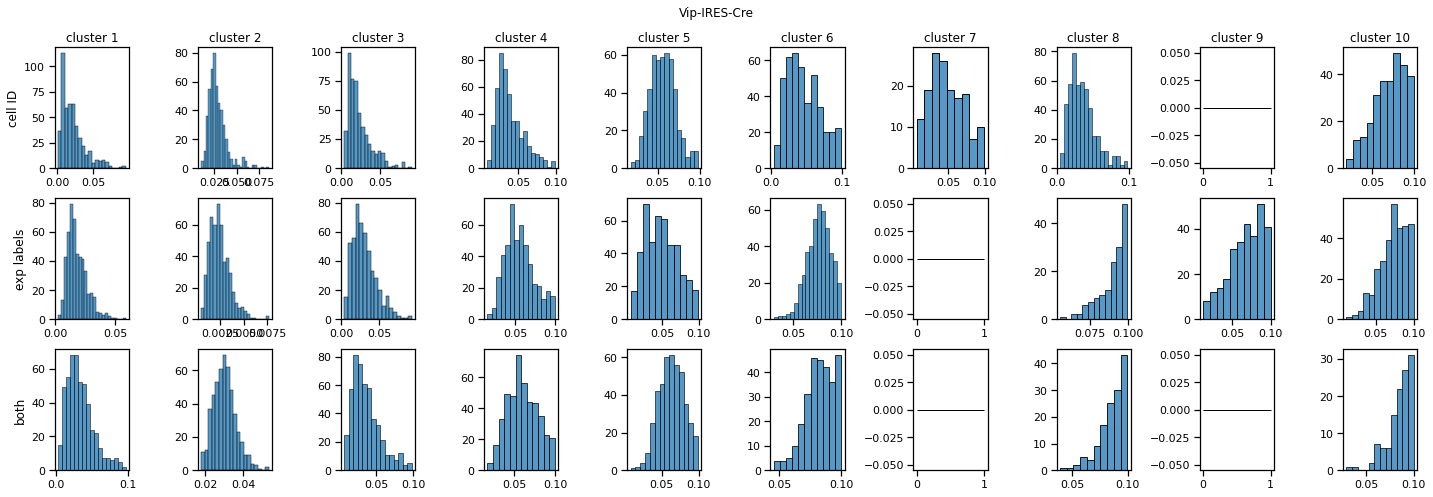

In [89]:
for c,cre_line in enumerate(cre_lines):
    fig = plt.figure(figsize=figsizes[c], )
    ax_i =1
    for s,shuffle_type in enumerate(shuffle_types):
        tmp = shuffle_type_SSE_values[shuffle_type][cre_line]
        cluster_ids = tmp.keys()
        
        for i,cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(3, len(cluster_ids), ax_i, )
            ax = sns.histplot(tmp[cluster_id], ax=ax, )
            if s == 0:
                ax.set_title(f'cluster {cluster_id}')
                
            if cluster_id !=1:
                ax.set_ylabel('')
            else:
                ax.set_ylabel(shuffle_type_dict[shuffle_type])
            ax_i=ax_i+1
            #ax.set_xlim([0, threshold])
    fig.suptitle(cre_line)
        
    plt.tight_layout()
    utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder=f'SSE_hist_by_cluster_{threshold}',
                          fig_title=f'SSE_hist_{cre_line}')
    
# this code blocke plots one row at a time (for easier editing if needed)
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
#         tmp = shuffle_type_SSE_values[shuffle_type][cre_line]
#         cluster_ids = tmp.keys()
#         fig, ax = plt.subplots(1,len(cluster_ids), figsize = (15,3), sharey = "row")
#         for i,cluster_id in enumerate(cluster_ids):
#             ax[i] = sns.histplot(tmp[cluster_id], ax=ax[i], )
#             ax[i].set_title(f'cluster {cluster_id}')
#             #ax[i].set_xlim([0, threshold])
#         plt.suptitle(shuffle_type + ' ' + cre_line)
#         plt.tight_layout()
#         utils.save_figure(fig, figsize = (15,3), save_dir=save_dir, folder='SSE_by_cluster',
#                           fig_title=f'SSE_hist_{cre_line}_{shuffle_type}_{threshold}')

### SSE matrix plots

In [31]:
# for shuffle_type in shuffle_types:
#     for cre_line in cre_lines:
#         for n, n_boot in enumerate(n_boots[:50]):
#             tmp = shuffle_type_SSE[shuffle_type][cre_line][n_boot]
#             labels=np.arange(1,len(tmp)+1)
#             fig, ax = plt.subplots(1,1,figsize = (10,10))
#             ax=sns.heatmap(tmp, annot=True, cmap = 'Greys', 
#                            yticklabels=labels, xticklabels=labels,ax=ax)
#             plt.suptitle(cre_line[:3]+ ' ' + shuffle_type + ' ' + str(n_boot))
#             plt.tight_layout()
#             utils.save_figure(fig, figsize = (10,10), save_dir=save_dir, folder='SSE', 
#                       fig_title=f'SSE_matrix{cre_line[:3]}_nb{n_boot}_{shuffle_type}')
#             plt.close('all')

#### Plot cluster heatmaps with SSE matrix together

In [91]:
#create unstacked mean dropout scores for each cluster for plotting
cre_original_clusters_unstacked = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df, stacked=False)
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    if cre_line == 'Slc17a7-IRES2-Cre':
        # reverse 4 and 5 cluster again. 
        mean_dropout_scores[100] = mean_dropout_scores.pop(4)
        mean_dropout_scores[4] = mean_dropout_scores.pop(5)
        mean_dropout_scores[5] = mean_dropout_scores.pop(100)
    cre_original_clusters_unstacked[cre_line] = mean_dropout_scores
            

#### plotting aligned clusters into one folder
This will make it easier to scroll through plots and to make sure that all matched clusters are well matched


In [92]:
#create unstacked mean dropout scores for each cluster for plotting
shuffle_type_mean_dropout_scores_unstacked = {} # shuffle types to compare
for shuffle_type in shuffle_types:
    cre_mean_dropout_scores_shuffled_unstacked = {} # cre lines to compare
    for cre_line in cre_lines:
        nb_mean_dropout_scores_shuffled = {}
        for n,n_boot in enumerate(n_boots):
            dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            cluster_df = shuffle_type_labels[shuffle_type][cre_line][n]
            #cluster_df = cluster_df.rename(mapper={'labels':'cluster_id'}, axis=1)
            mean_dropout_scores_unstacked = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                      cluster_df = cluster_df, stacked=False)
            nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores_unstacked
        cre_mean_dropout_scores_shuffled_unstacked[cre_line] = nb_mean_dropout_scores_shuffled
    shuffle_type_mean_dropout_scores_unstacked[shuffle_type] = cre_mean_dropout_scores_shuffled_unstacked

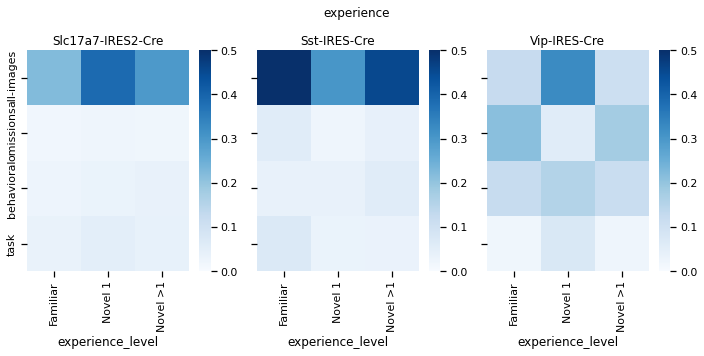

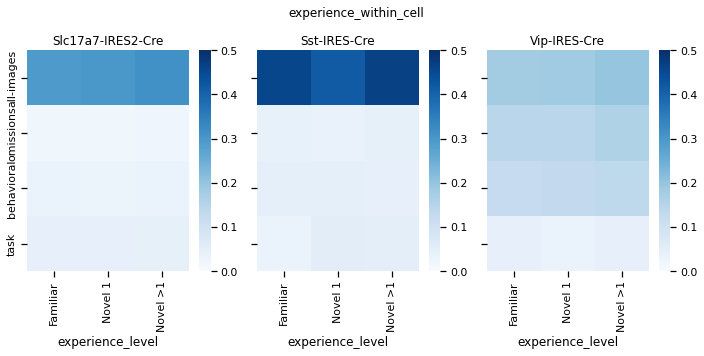

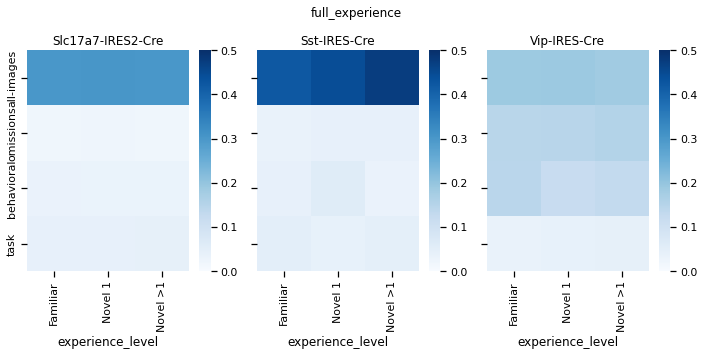

In [93]:
### pot mean of shuffled dropout scores regardless of clusters.
for shuffle_type in shuffle_types:
    fig, ax = plt.subplots(1,3, figsize = (10,5), sharey='row')
    for c, cre_line in enumerate(cre_lines):
        for n, n_boot in enumerate(n_boots):
            if n ==0:
                dropout_scores = shuffle_type_df[shuffle_type][cre_line][n]
            else:
                dropout_scores.append(shuffle_type_df[shuffle_type][cre_line][n], ignore_index=True)
        mean_df = dropout_scores.mean().unstack()
        features = vba_clust.get_features_for_clustering()
        mean_df = mean_df.loc[features]
        ax[c] = sns.heatmap(mean_df, cmap='Blues', ax=ax[c], vmin=0, vmax=0.5)
        ax[c].set_title(cre_line)
    plt.suptitle(shuffle_type)
    plt.tight_layout()
    utils.save_figure(fig, figsize = (10,5), save_dir=save_dir, folder='', fig_title=f'mean_dropout_scores_{shuffle_type}_{threshold}')

In [94]:
threshold_probabilities = {}
for threshold in thresholds:
    shuffle_type_probabilities = {}
    shuffle_type_SSE_mapping = threshold_SSE_mapping[threshold]
    for shuffle_type in shuffle_types:
        cre_cluster_probabilities = {}
        for cre_line in cre_lines:
            SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
            cre_cluster_probabilities[cre_line] = vba_clust.compute_probabilities(SSE_mapping)
        shuffle_type_probabilities[shuffle_type] = cre_cluster_probabilities
    threshold_probabilities[threshold] = shuffle_type_probabilities

In [96]:
for threshold in thresholds:
    for shuffle_type in shuffle_types:
        filename = 'cre_cluster_probabilities_{}_{}.pkl'.format(shuffle_type, str(threshold))
        vba_clust.save_clustering_results(threshold_probabilities[threshold][shuffle_type], os.path.join(save_dir, 'files', filename))

In [97]:
threshold_cluster_sizes = {}
for threshold in thresholds:
    shuffle_type_cluster_sizes = {}
    shuffle_type_SSE_mapping = threshold_SSE_mapping[threshold]
    for shuffle_type in shuffle_types:
        cre_cluster_sizes = {}
        for cre_line in cre_lines:
            SSE_mapping = shuffle_type_SSE_mapping[shuffle_type][cre_line]
            cluster_df_shuffled = shuffle_type_labels[shuffle_type][cre_line]
            all_cluster_sizes = vba_clust.get_cluster_size_variance(SSE_mapping, cluster_df_shuffled, use_nan=False)
            cre_cluster_sizes[cre_line] = all_cluster_sizes 
        shuffle_type_cluster_sizes[shuffle_type] = cre_cluster_sizes
    threshold_cluster_sizes[threshold] = shuffle_type_cluster_sizes

In [98]:
for threshold in thresholds:
    for shuffle_type in shuffle_types:
        filename = 'cre_cluster_sizes_{}_{}.pkl'.format(shuffle_type, threshold)
        vba_clust.save_clustering_results(threshold_cluster_sizes[threshold][shuffle_type], os.path.join(save_dir, 'files', filename))

### Plot proportions for matched clusters

In [99]:
cre_original_cluster_sizes = {}
for cre_line in cre_lines:
    tmp = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    cre_original_cluster_sizes[cre_line] = tmp.value_counts('cluster_id')
    

In [100]:
# shuffle_type_cluster_sizes = {}
# for shuffle_type in shuffle_types:
#     filename = 'cre_cluster_sizes_{}_220802.pkl'.format(shuffle_type)
#     full_path = os.path.join(save_dir,filename)
#     with open(full_path, 'rb') as f:
#         shuffle_type_cluster_sizes[shuffle_type] = pkl.load(f)
#         f.close()


In [101]:
# shuffle_type_probabilities = {}
# for shuffle_type in shuffle_types:
#     filename = 'cre_cluster_probabilities_{}_220802.pkl'.format(shuffle_type)
#     full_path = os.path.join(save_dir, filename)
#     with open(full_path, 'rb') as f:
#         shuffle_type_probabilities[shuffle_type] = pkl.load(f)
#         f.close()

In [102]:
probability_dict = {}
for threshold in thresholds:
    shuffle_type_probabilities = threshold_probabilities[threshold]
    probability_dict[threshold]= vba_clust.get_cluster_probability_df(shuffle_type_probabilities)

In [103]:
cluster_size_difference_dict = {}
for threshold in thresholds:
    shuffle_type_cluster_sizes = threshold_cluster_sizes[threshold]
    cluster_size_difference_dict[threshold] = vba_clust.get_cluster_size_differece_df(cre_original_cluster_sizes, shuffle_type_cluster_sizes)

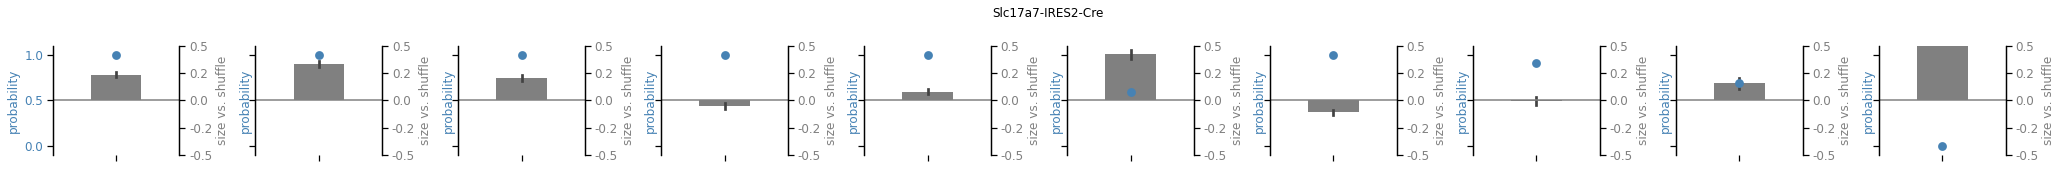

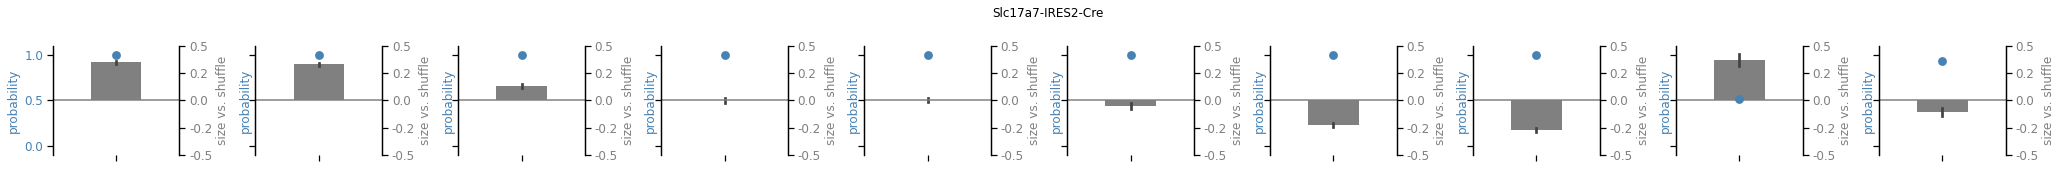

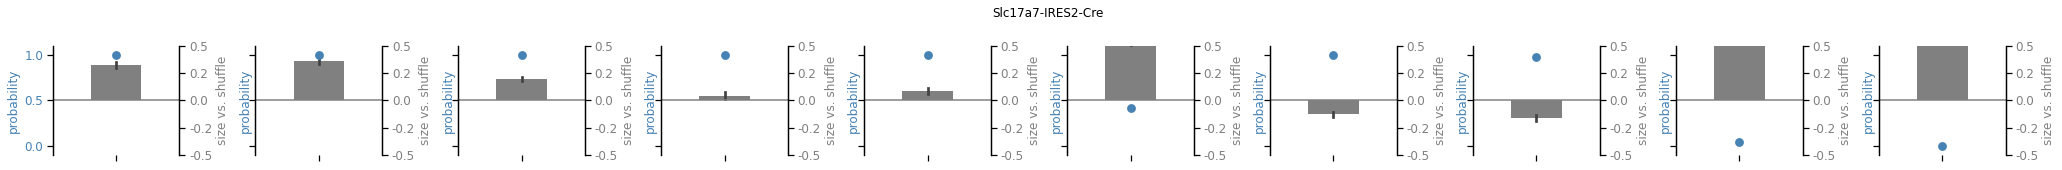

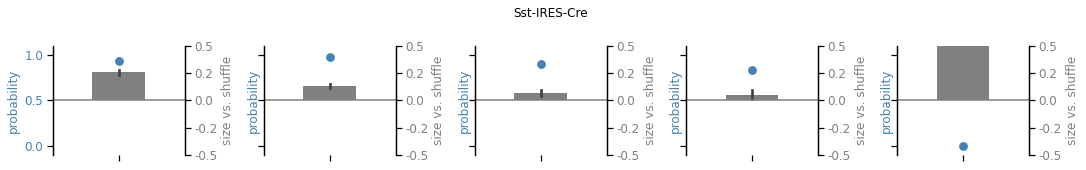

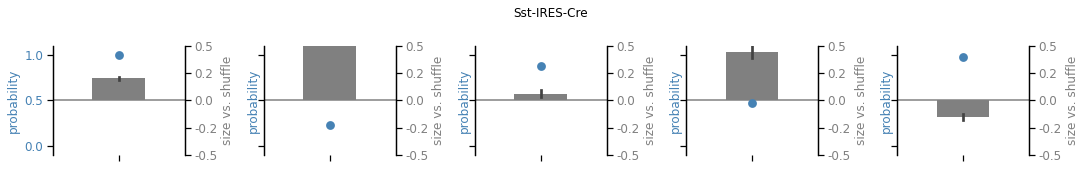

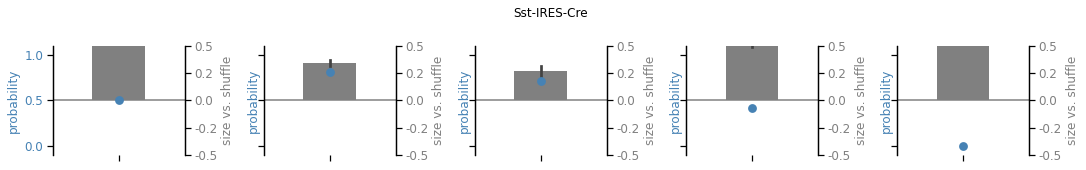

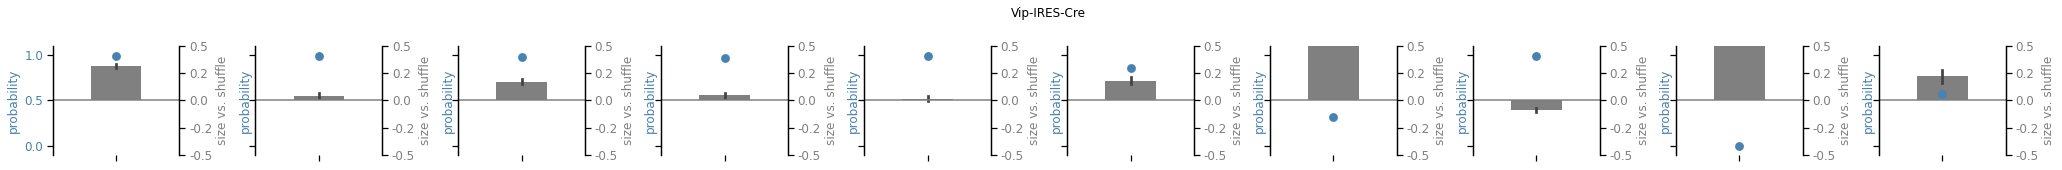

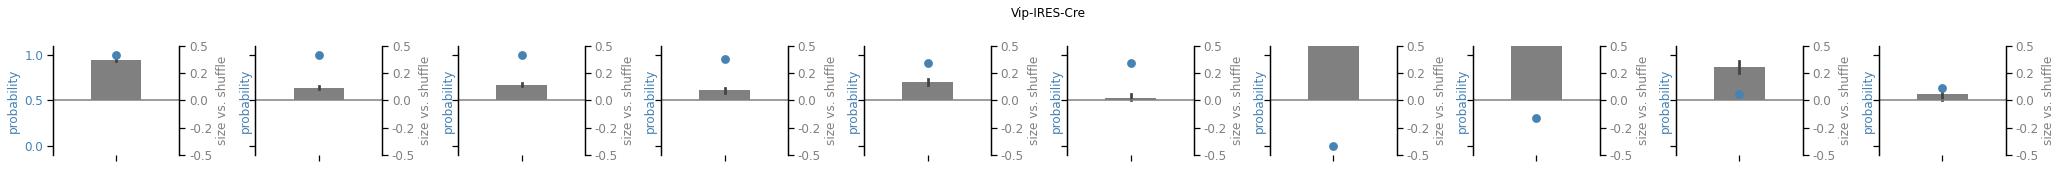

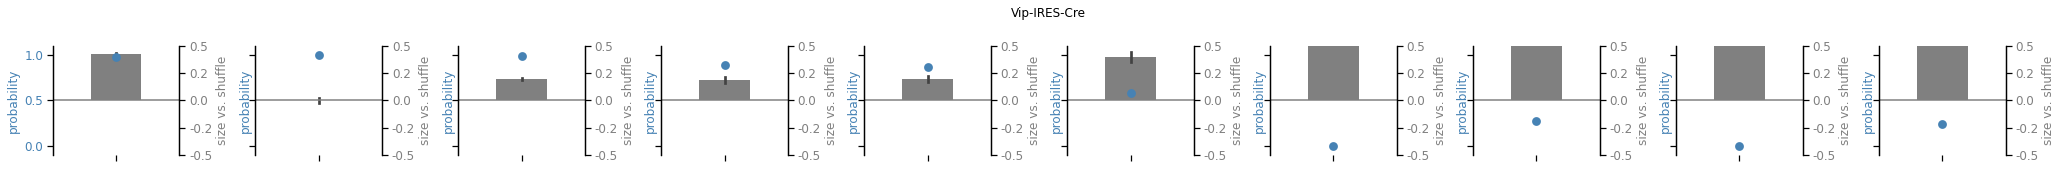

In [104]:
%%capture --no-display 
for threshold in thresholds:
    for cre_line in cre_lines:
        for s, shuffle_type in enumerate(shuffle_types):
            vba_clust.plot_cluster_size_and_probability(cluster_size_difference_dict[threshold], 
                                                        probability_dict[threshold], 
                                                        cre_line=cre_line, 
                                                        shuffle_type=shuffle_type,
                                                       save_dir=save_dir,
                                                       folder = f'{shuffle_type}{threshold}')


#### plot mean heatmap of matched clusters

to do:
    fix this plotting function

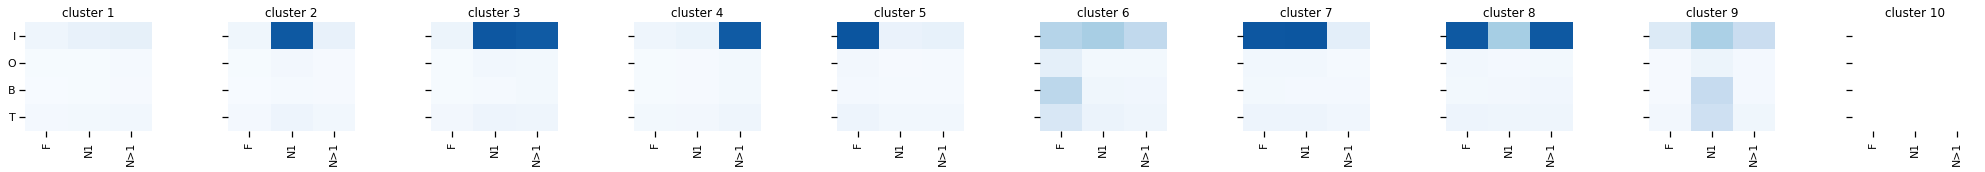

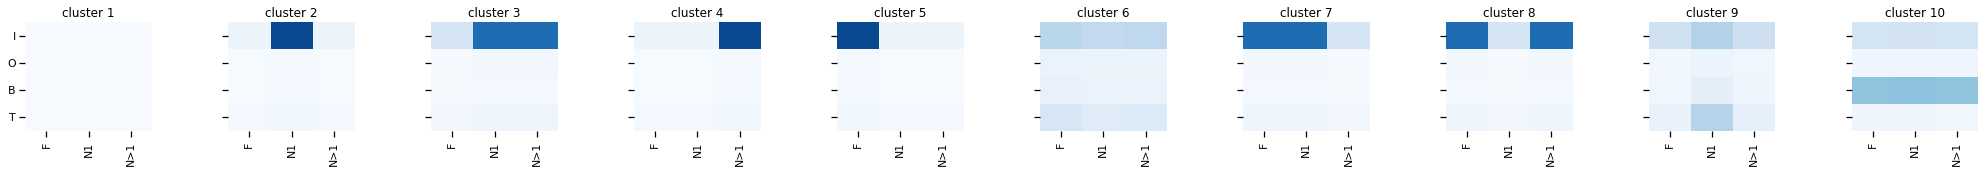

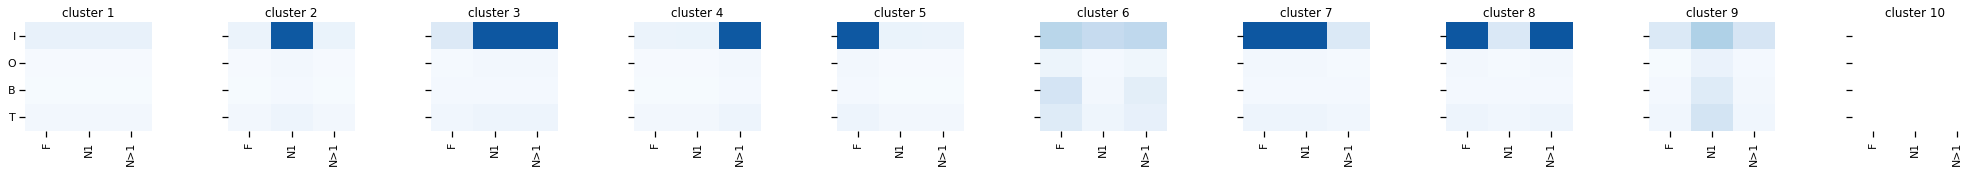

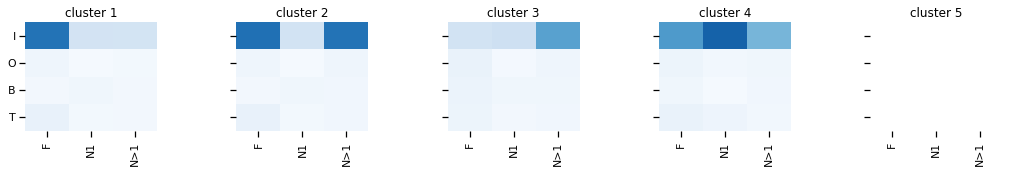

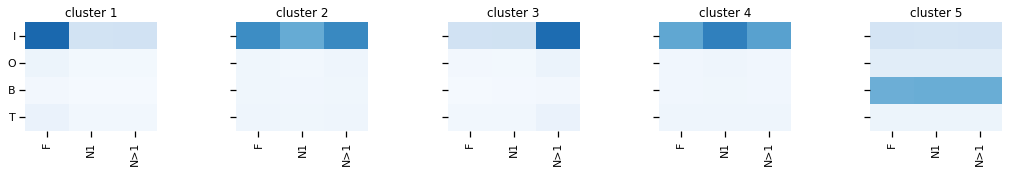

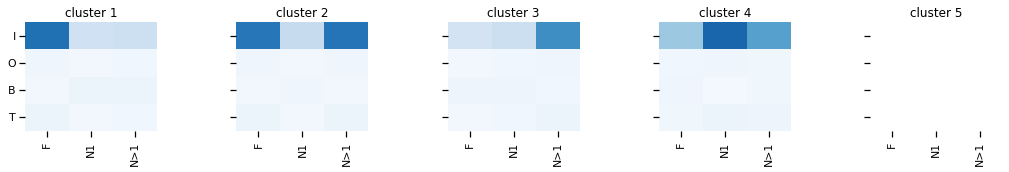

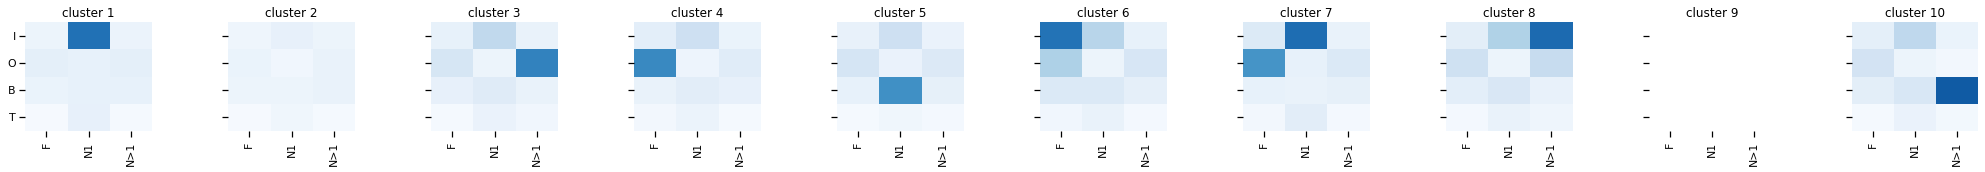

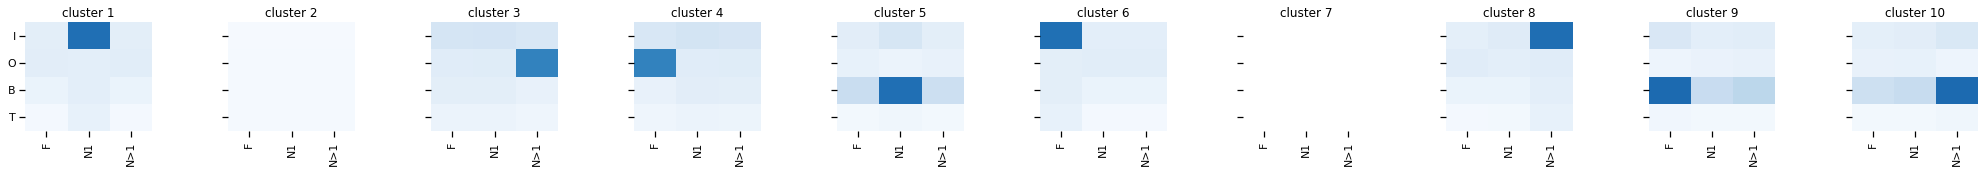

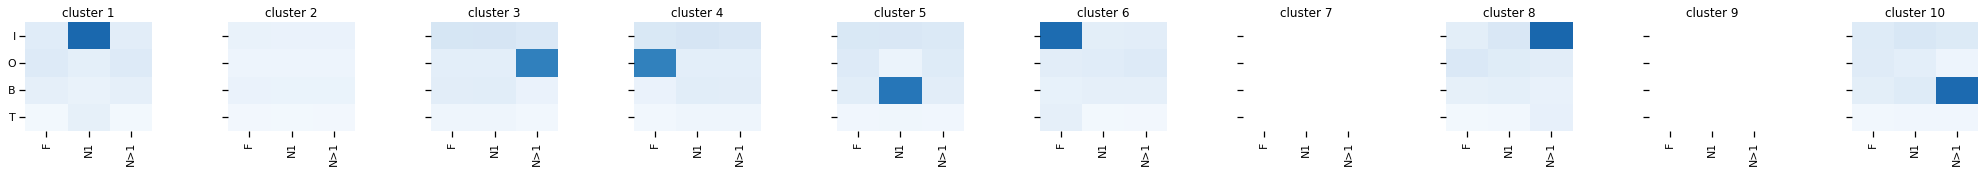

In [105]:
for threshold in thresholds:
    for cre_line in cre_lines:
        for shuffle_type in shuffle_types:
            vba_clust.plot_matched_clusters_heatmap(SSE_mapping = threshold_SSE_mapping[threshold], 
                                                    mean_dropout_scores_unstacked= shuffle_type_mean_dropout_scores_unstacked ,
                                                    cre_line=cre_line, metric='mean',
                                                    shuffle_type=shuffle_type, save_dir=save_dir, folder=f'{shuffle_type}{threshold}')



In [106]:
threshold_corr_dict = {}
for threshold in thresholds:
    shuffle_corr_dict = {}
    for shuffle_type in shuffle_types:
        corr_dict = {}
        for cre_line in cre_lines:
            corr_dict[cre_line]= vba_clust.get_corr_for_matched_clusters_dict(shuffle_type_SSE_mapping, 
                                                           shuffle_type_mean_dropout_scores,
                                                            shuffle_type = shuffle_type,
                                                           cre_line = cre_line)
        shuffle_corr_dict[shuffle_type] = corr_dict
    threshold_corr_dict[threshold] = shuffle_corr_dict

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


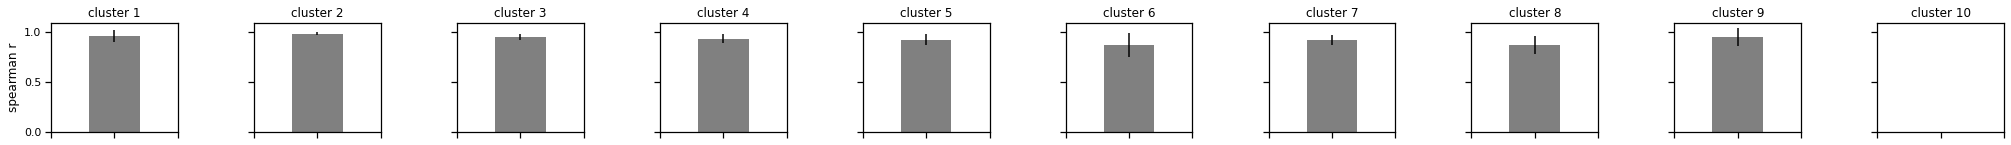

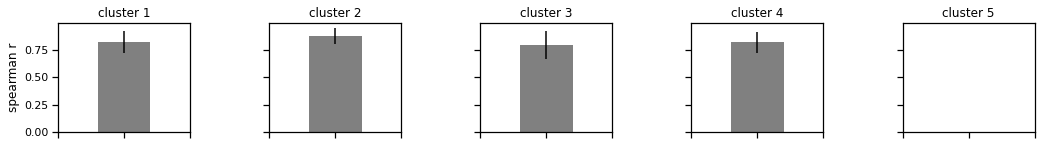

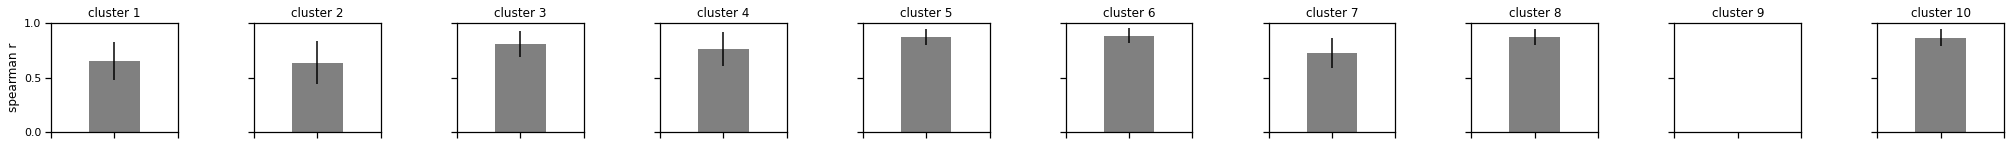

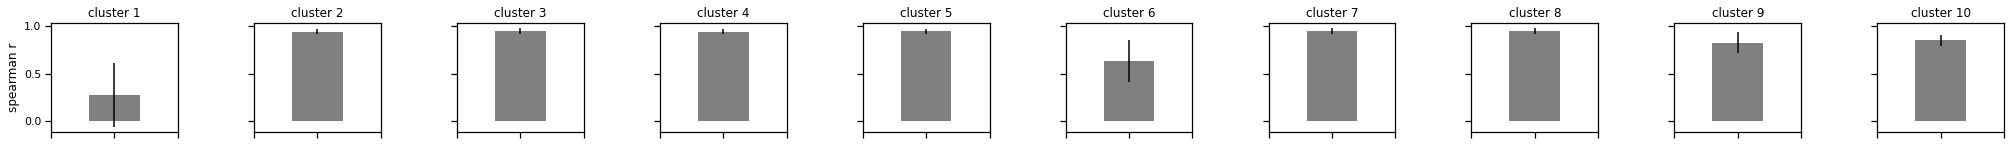

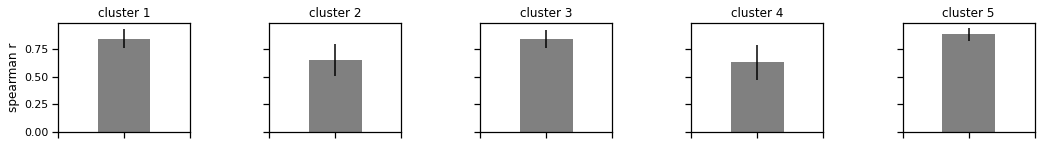

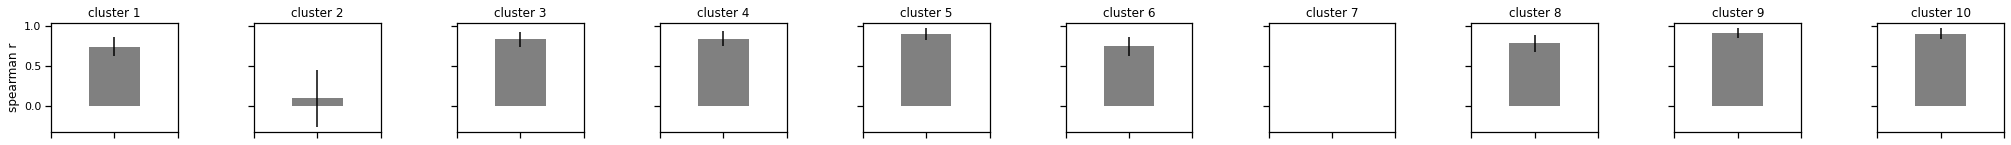

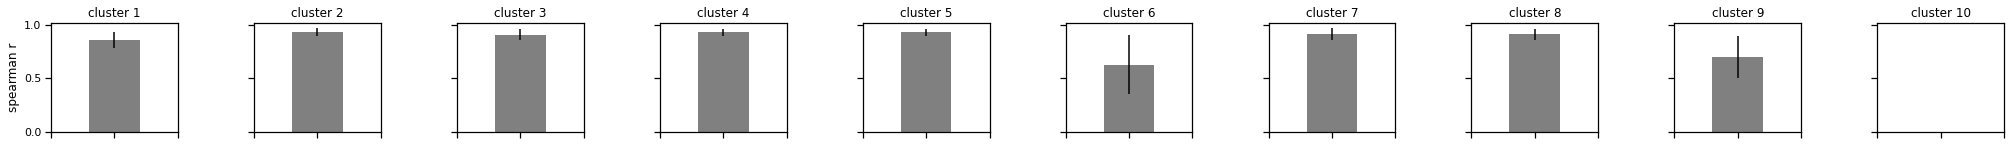

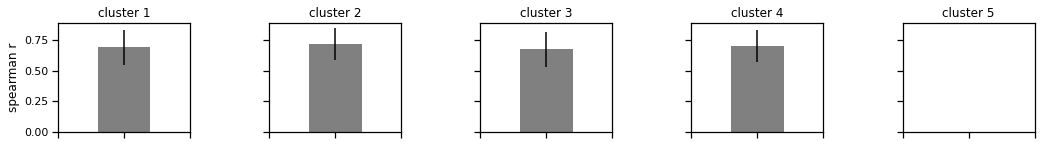

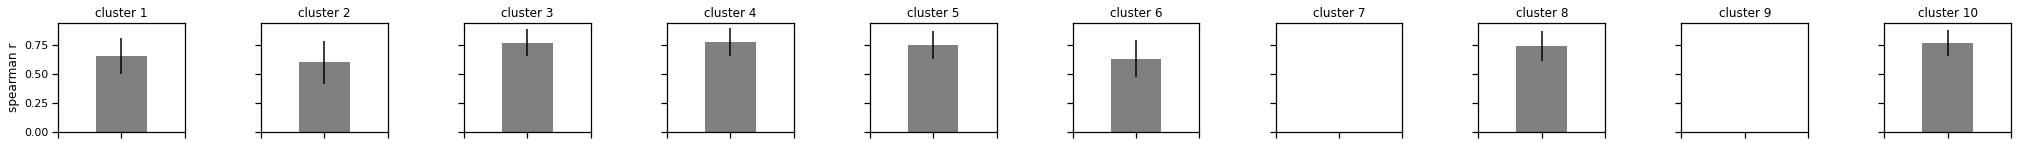

In [107]:
for threshold in thresholds:
    for shuffle_type in shuffle_types:
        for cre_line in cre_lines:
            corr_dict = threshold_corr_dict[threshold][shuffle_type][cre_line]
            n_clusters = len(corr_dict.keys())
            figsize=(3.5*n_clusters,2)
            fig, ax = plt.subplots(1,n_clusters, figsize = figsize, sharey='row')
            for i, cluster_id in  enumerate(corr_dict.keys()):
                ax[i].bar(cluster_id, corr_dict[cluster_id][0], color='Grey')
                ax[i].errorbar(cluster_id, corr_dict[cluster_id][0], corr_dict[cluster_id][1], 
                            color='k')
                ax[i].set_xticklabels([cluster_id])
                if i ==0 :
                    ax[i].set_ylabel('spearman r')
                ax[i].set_xlabel('')
                ax[i].set_title(f'cluster {cluster_id}')
                ax[i].set_xticklabels('')
                ax[i].set_xlim([cluster_id-1, cluster_id+1])

            #plt.suptitle(cre_line + ' ' + shuffle_type)
            fig.subplots_adjust(hspace=1.2, wspace=0.6)
            utils.save_figure(fig, figsize, save_dir, f'{shuffle_type}{threshold}',
                          f'{shuffle_type}_spearman_within_matched_' + cre_line[:3]  )


### try to match SSE values for mean plots

In [108]:
def make_dict(matrix):
    rows = np.shape(matrix)[0]
    new_dict = {}
    for row in range(rows):
        new_dict[row+1] = matrix[row]
    
    return new_dict

In [109]:
%%time

shuffle_type_SSE_all = {}
for shuffle_type in shuffle_types:
    cre_SSE_all = {}
    for cre_line in cre_lines:
        
        n_boots = shuffle_type_SSE[shuffle_type][cre_line].keys()
        cluster_ids = shuffle_type_SSE_mapping[shuffle_type][cre_line][0]
        
        # create a data frame to collect sorted SSE from all n_boots
        SSE_values_sorted_df = pd.DataFrame(columns=['cluster_id', *cluster_ids])
        
        # run over all nboots and sort SSE using orignal cluster sort
        for n in n_boots:
            
            # Get matched map and SSE matrix for this n boot
            SSE_values = shuffle_type_SSE[shuffle_type][cre_line][n]
            SSE_map = threshold_SSE_mapping[threshold][shuffle_type][cre_line][n]
            #print(SSE_map)
            # convert SSE matrix to df for easier operation
            nb_values_df = pd.DataFrame(make_dict(SSE_values))
            #print(nb_values_df)
            # make a copy which will be used to store sorted SSE values
            nb_sorted_df = nb_values_df.copy()
            # first sort SSE values
            for cluster_id in SSE_map.keys():
                matched_cluster_id = SSE_map[cluster_id] # matched shuddled cluster id
                
                # copy matched SSE value to a new location in df
                if matched_cluster_id!=-1:
                    nb_sorted_df.loc[cluster_id-1][:] = nb_values_df.loc[matched_cluster_id-1][:].values
                else:
                    #nb_sorted_df.loc[cluster_id-1][cluster_id]=np.nan
                    nb_sorted_df.loc[cluster_id-1][:]=np.nan
            
            
            # reset index and rename cluster id column
            nb_sorted_df = nb_sorted_df.reset_index(drop=True)
            nb_sorted_df['cluster_id'] = np.arange(1, len(cluster_ids)+1)
            
            
            # append to larger df with all n_boots
            SSE_values_sorted_df = SSE_values_sorted_df.append(nb_sorted_df, ignore_index=True)
        cre_SSE_all[cre_line] = SSE_values_sorted_df
    shuffle_type_SSE_all[shuffle_type] = cre_SSE_all
                
    
    

Wall time: 17.5 s


#### plot heatmap of mean SSE values by with cluster id heatmaps

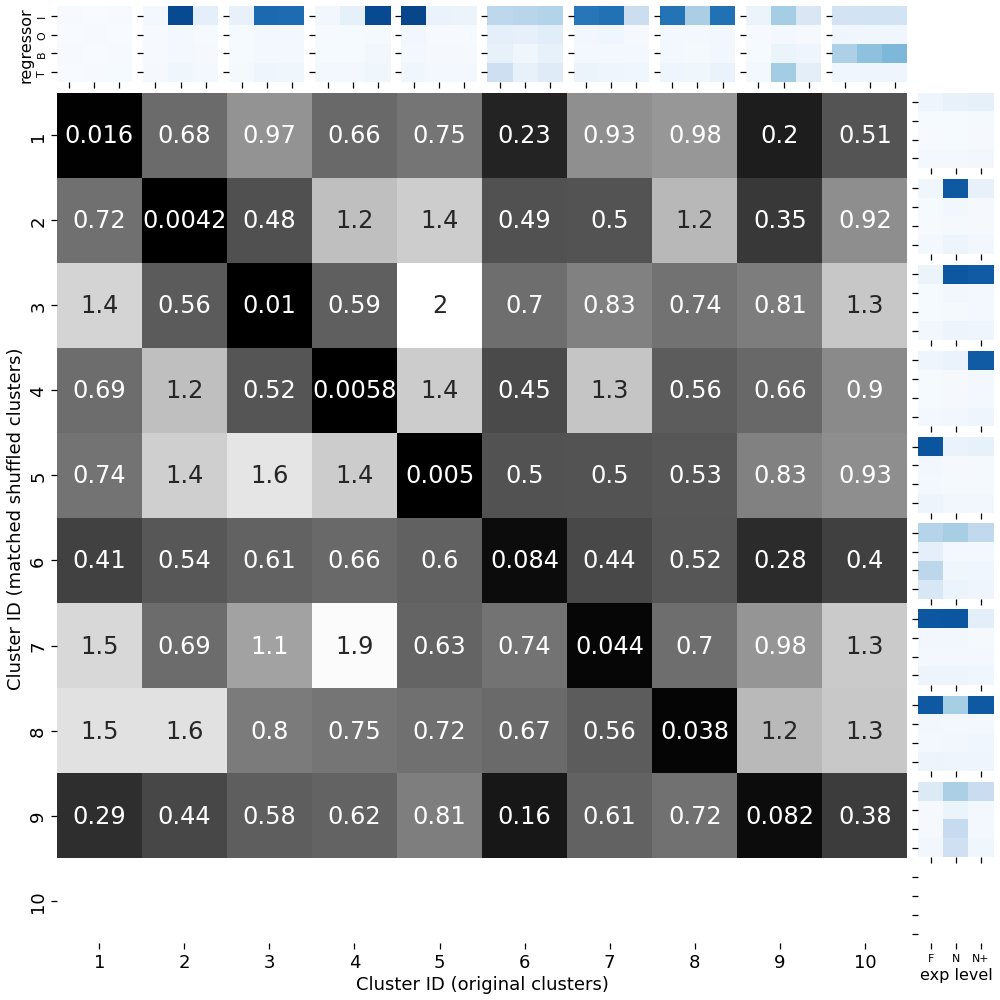

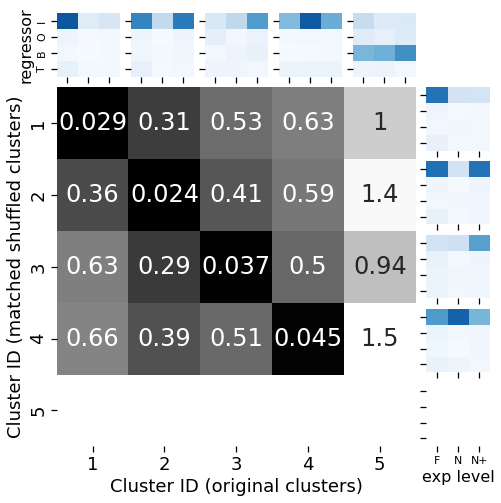

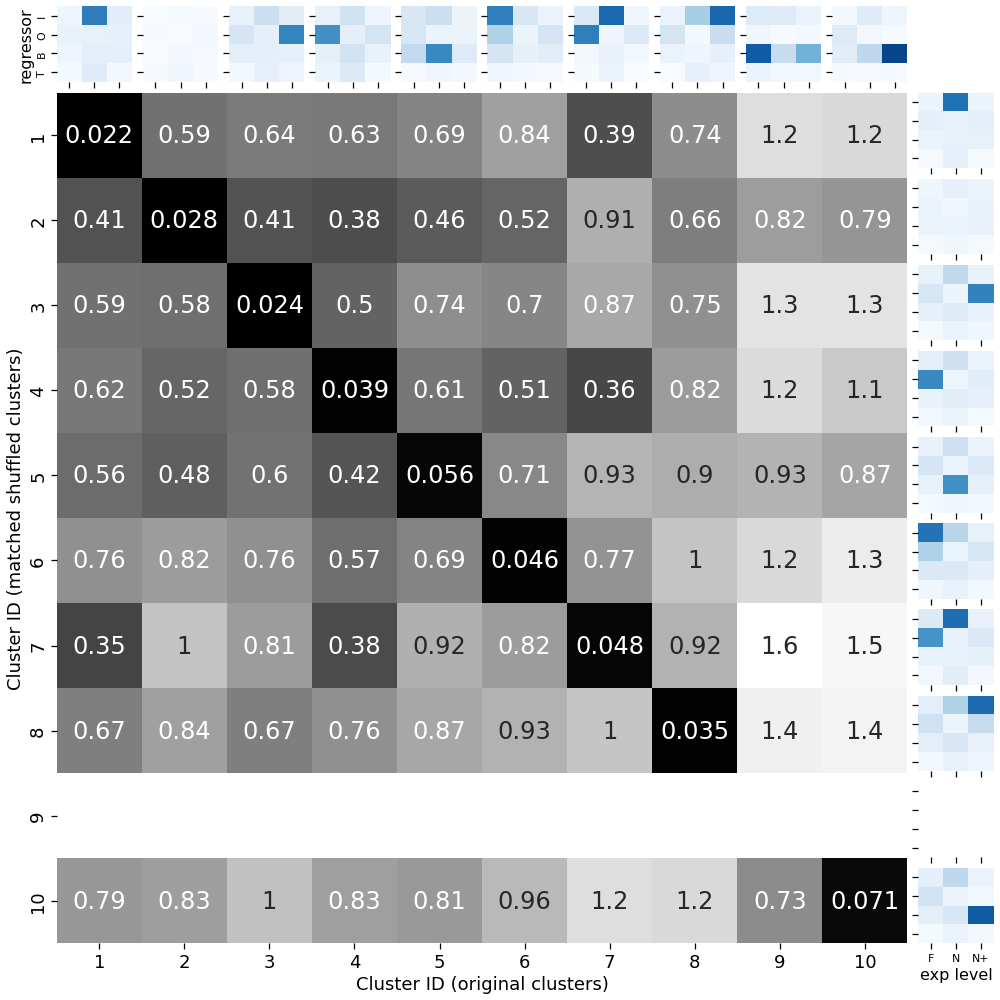

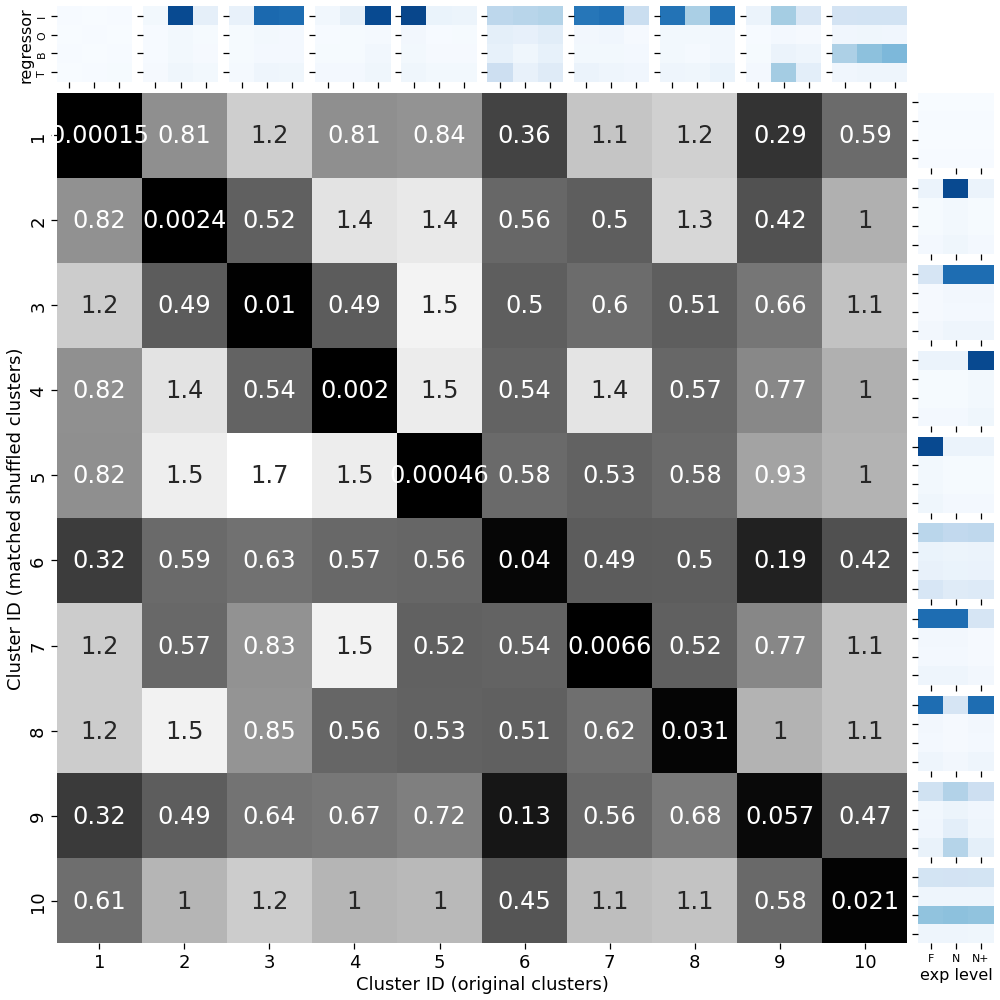

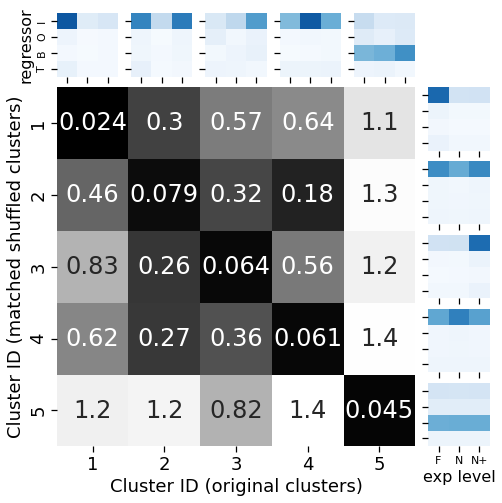

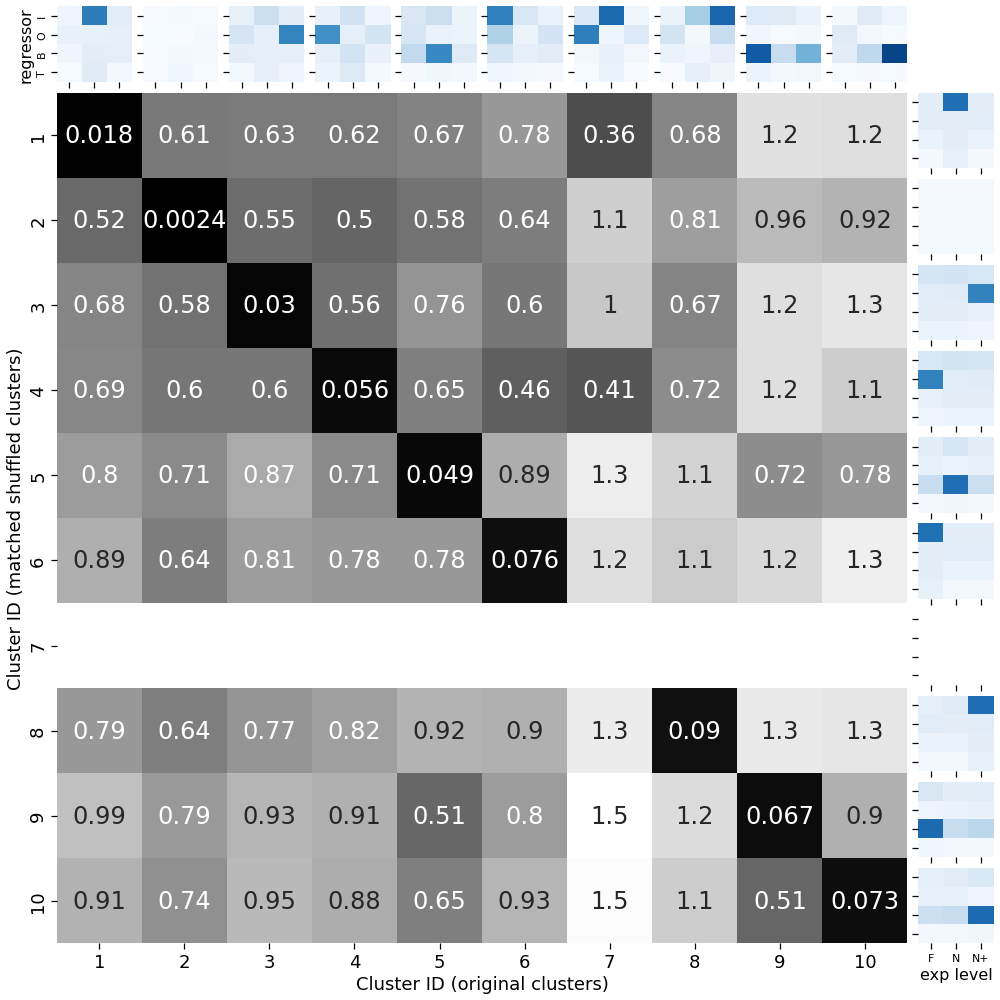

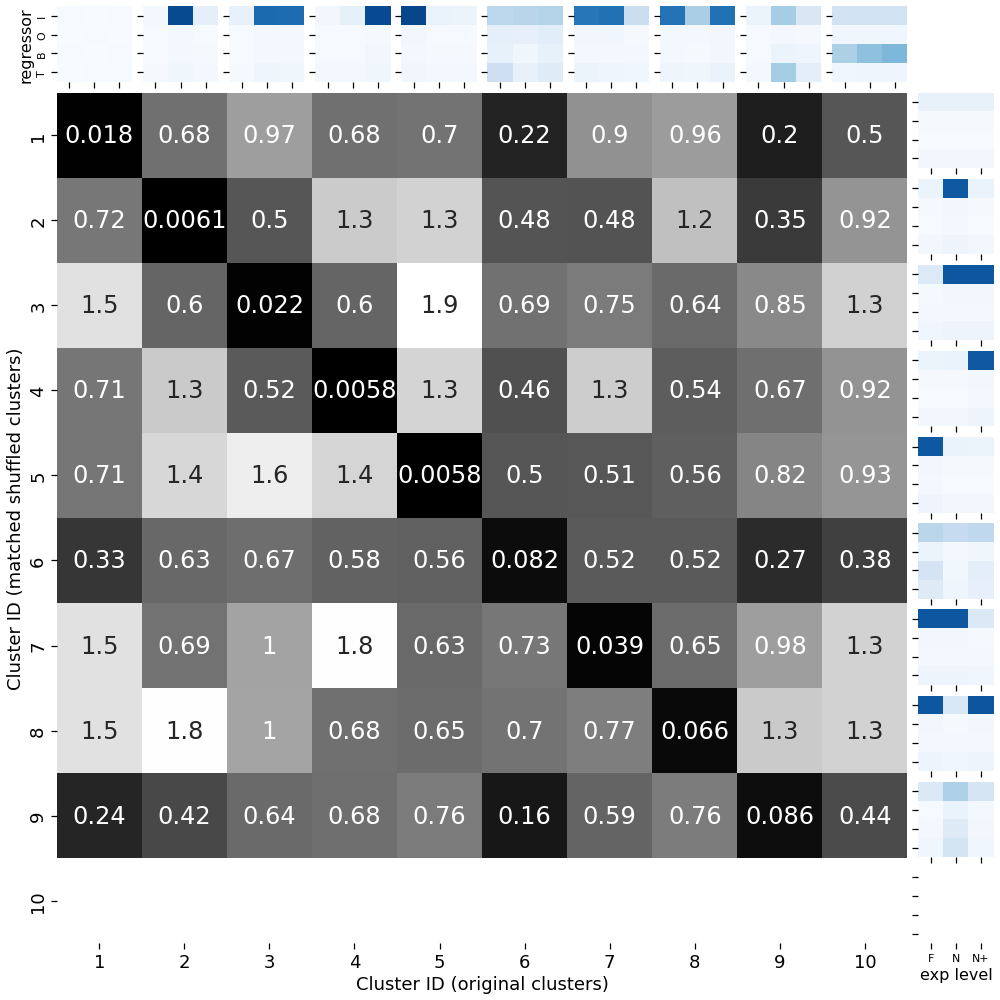

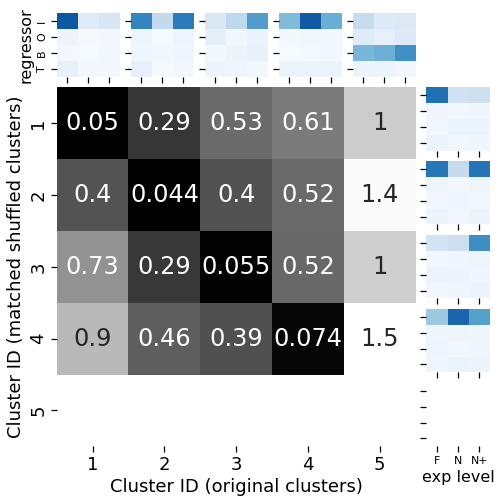

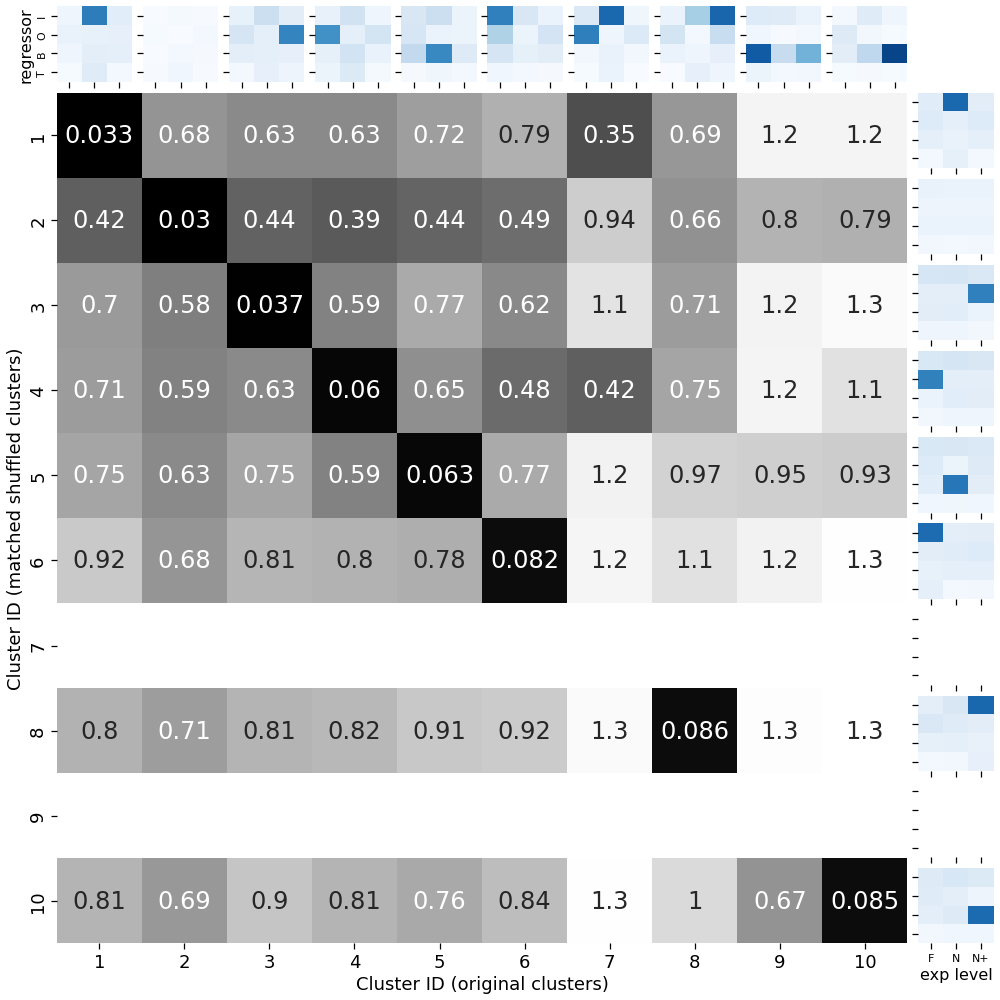

In [115]:
### make one mean figure with diagonal SSE matching plot

import matplotlib.gridspec as gr
figsizes =  [(14,14), (7, 7), (14,14)]
for shuffle_type in shuffle_types:
    for c,cre_line in enumerate(cre_lines):
        SSE_mapping = threshold_SSE_mapping[threshold]
        
        shuffled = vba_clust.get_matched_clusters_means_dict(SSE_mapping, shuffle_type_mean_dropout_scores_unstacked, metric='mean', shuffle_type=shuffle_type,
                                    cre_line=cre_line)      
        original = cre_original_clusters_unstacked[cre_line]
        cluster_ids = shuffled.keys()
        n_clusters = len(cluster_ids)
            
            
        gs = gr.GridSpec(n_clusters+1, n_clusters+1, width_ratios=[2]*(n_clusters+1), height_ratios=[2]*(n_clusters+1))
        fig = plt.figure(figsize = figsizes[c])
            
        # plot original
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[0, i])
            ax = sns.heatmap(original[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            if i!=0:
                ax.set_yticklabels('')
            else:
                ax.set_ylabel('regressor', fontsize=16)
            ax.set_xticklabels('')
            ax.set_xlabel('')

        # plot shuffled clusters
        for i, cluster_id in enumerate(cluster_ids):
            ax = fig.add_subplot(gs[cluster_id, n_clusters])
            if shuffled[cluster_id].sum().sum() != 0:
                ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Blues",vmin=0, vmax=1,cbar=False, ax=ax)
            else:
                ax = sns.heatmap(shuffled[cluster_id].loc[vba_clust.get_features_for_clustering()],
                xticklabels=['F', 'N', 'N+'],yticklabels=['I', 'O', 'B', 'T'],
                cmap = "Greys",vmin=0, vmax=1,cbar=False, ax=ax)
                
            ax.set_yticklabels('')
            ax.set_xlabel('')
            ax.set_ylabel('')
            if cluster_id !=n_clusters:
                ax.set_xticklabels('')
            else:
                ax.set_xlabel('exp level', fontsize=16)


         # Plot SSE
        tmp = shuffle_type_SSE_all[shuffle_type][cre_line].groupby('cluster_id').mean()        
        labels=np.arange(1,len(tmp)+1)
        ax = fig.add_subplot(gs[1:,:n_clusters])
        ax=sns.heatmap(tmp, annot=True, cmap = 'Greys_r', annot_kws= {"size": 24},
                            yticklabels=labels, xticklabels=labels,cbar=False,ax=ax)
        
        ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
        ax.set_ylabel('Cluster ID (matched shuffled clusters)', fontsize=18)
        ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
        ax.set_xlabel('Cluster ID (original clusters)', fontsize=18)

        plt.tight_layout()
        utils.save_figure(fig, figsize = figsizes[c], save_dir=save_dir, folder='mean_SSE_plots',
                      fig_title=f'mean_SSE_heatmap_{shuffle_type}_{cre_line[:3]}')
        


In [116]:
from scipy.stats import chisquare
from scipy.stats import power_divergence
from scipy.stats import fisher_exact

In [58]:
cluster_size_difference_dict[threshold]
                                                        

,cre_line,cluster_id,shuffle_type,n_boot,cluster_size_diff
0,Slc17a7-IRES2-Cre,1,experience,0,0.071167
1,Slc17a7-IRES2-Cre,1,experience,1,-0.094854
2,Slc17a7-IRES2-Cre,1,experience,2,0.457086
3,Slc17a7-IRES2-Cre,1,experience,3,-0.086929
4,Slc17a7-IRES2-Cre,1,experience,4,0.081481
...,...,...,...,...,...
37495,Vip-IRES-Cre,10,full_experience,495,NaN
37496,Vip-IRES-Cre,10,full_experience,496,-0.388889
37497,Vip-IRES-Cre,10,full_experience,497,-0.463415
37498,Vip-IRES-Cre,10,full_experience,498,-0.333333


In [59]:
probability_dict[threshold]

,cre_line,cluster_id,shuffle_type,probability
0,Slc17a7-IRES2-Cre,1,experience,1.000
1,Slc17a7-IRES2-Cre,2,experience,1.000
2,Slc17a7-IRES2-Cre,3,experience,1.000
3,Slc17a7-IRES2-Cre,4,experience,1.000
4,Slc17a7-IRES2-Cre,5,experience,1.000
...,...,...,...,...
70,Vip-IRES-Cre,6,full_experience,0.578
71,Vip-IRES-Cre,7,full_experience,0.000
72,Vip-IRES-Cre,8,full_experience,0.274
73,Vip-IRES-Cre,9,full_experience,0.000
